# 23 - Challenges with Effect Heterogeneity and Nonlinearity

Predicting treatment effects at the unit level is extremely difficult due to the lack of ground truth. Since we only observe one potential outcome $T(t)$, we can't directly estimate it. Rather, we have to rely on target transformations (that can also be viewed as cleverly designed loss function) to estimate conditional treatment effects only in expectation. But that is not the only challenge. Because treatment effects are so slippery, its estimators are often quite noisy. This has huge practical consequences for applications where we want to segment units by their treatment effect, like when we want to do personalized treatment allocation.

We will now see that, sometimes, we can get a better treatment effect segmentation if we don't directly try to estimate CATE, but instead focus on another proxy target, which usually has less variance. A common case when this happens is when the outcome variable of interest $Y$ is binary.

## Treatment Effects on Binary Outcomes




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")


In [3]:
from typing import List

import numpy as np
import pandas as pd
from toolz import curry, partial

@curry
def avg_treatment_effect(df, treatment, outcome):
    return df.loc[df[treatment] == 1][outcome].mean() - df.loc[df[treatment] == 0][outcome].mean()
    
    

@curry
def cumulative_effect_curve(df: pd.DataFrame,
                            treatment: str,
                            outcome: str,
                            prediction: str,
                            min_rows: int = 30,
                            steps: int = 100,
                            effect_fn = avg_treatment_effect) -> np.ndarray:
    
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([effect_fn(ordered_df.head(rows), treatment, outcome) for rows in n_rows])


@curry
def cumulative_gain_curve(df: pd.DataFrame,
                          treatment: str,
                          outcome: str,
                          prediction: str,
                          min_rows: int = 30,
                          steps: int = 100,
                          effect_fn = avg_treatment_effect) -> np.ndarray:
    

    size = df.shape[0]
    n_rows = list(range(min_rows, size, size // steps)) + [size]

    cum_effect = cumulative_effect_curve(df=df, treatment=treatment, outcome=outcome, prediction=prediction,
                                         min_rows=min_rows, steps=steps, effect_fn=effect_fn)

    return np.array([effect * (rows / size) for rows, effect in zip(n_rows, cum_effect)])


Here is an incredibly common problem you might face if you find yourself working for a tech company: management wants to boost customer conversion to your product by means of some sort of nudge. For example, they might want to increase the number of app installs by offering a 10 BRL voucher for customers to make in-app purchases. Or offer a free ride the first time you use their ride sharing app. Or decrease transaction fees in the first three months in their investment platform. Since nudges are often expensive, they would love to not have to do it for everyone. Rather, it would be great if we could use the conversion boosting nudge only on those customers who are most sensitive to it.
 
In causal inference terms, you can probably tell by now that this type of business problem falls under the treatment effect heterogeneity (TEH) umbrella. Specifically, you have a costly nudge as the treatment $T$, conversion as the binary outcome $Y$ and customer specific pre-treatment features as $X$. You could then estimate the conditional average treatment effect $E[Y_1 - Y_0|X]$ (or $E[Y'(T)|X]$ if the treatment is continuous)$ with something like Double/Debiased ML and finally target with the nudge only the customers with the highest estimated treatment effect. In business terms, you would be personalizing your conversion strategy. You would be finding a segment of customers with high conversion incrementality and using nudges only in them.
 
However, there is one complication here that makes the TEH approach not so obvious. The fact that the outcome is binary complicates things considerably. Because this is a bit counter intuitive, I rather show what happens first and then explain why it happens.
 
## Simulating Some Data
 
Let's keep this very simple, but still relatable. We will simulate the treatment, `nudge`, as being completely random, drawn from a Bernoulli with $p=0.5$. This means the treatment is assigned according to a fair coin. It also means there is no confounding we need to watch out for.
 
$ nudge \sim \mathcal{B}(0.5) $
 
Next, let's simulate the customers' covariates `age` and `income` following a Gamma distribution. These are the stuff you know about the customer and hence, you want to personalize based on them. In other words, you wish to find groups of customers defined by age and income in such a way that one group is highly responsive to the `nudge` treatment.
 
$ age \sim G(10, 4) $
 
$ income \sim G(20, 2) $
 
Finally, we will simulate the conversion. For that, we will first **create a latent variable that follows a linear model** with random noise. Importantly, notice that `income` is highly predictive of $Y_{latent}$, but **it does not modify the treatment effect**. Put simply, nudge increases $Y_{latent}$ the same for all levels of `income`. In contrast, `age` only affects $Y_{latent}$ through its interaction with the `nudge` treatment. 
 
$Y_{latent} \sim N(-4.5 + 0.001 \ income + nudge + 0.01 \ nudge \ age, 1)$
 
Once we have the $Y_{latent}$, we can simulate `conversion` by setting it to $Y_{latent}>x$. First, let's set `x=0` so that the conversion is roughly 50\%. That is, on average 50\% of customers convert to our product.
 
$conversion = 1\{Y_{latent} > 0\}$




In [4]:
np.random.seed(123)

n = 100000
nudge = np.random.binomial(1, 0.5, n)
age = np.random.gamma(10, 4, n)
estimated_income = np.random.gamma(20, 2, n)*100

latent_outcome = np.random.normal(-4.5 + estimated_income*0.001 + nudge + nudge*age*0.01)
conversion = (latent_outcome > .1).astype(int)

Let's also  store everything in a DataFrame for convenience. Also, check that, indeed, the average conversion is close to 50%. 

In [5]:
df = pd.DataFrame(dict(conversion=conversion,
                       nudge=nudge,
                       age=age,
                       estimated_income=estimated_income,
                       latent_outcome=latent_outcome))

df.mean()

conversion             0.518260
nudge                  0.500940
age                   40.013487
estimated_income    3995.489527
latent_outcome         0.197076
dtype: float64

As for the average treatment effect, since the treatment was randomized, we can estimate it as the simple difference in means between treated and control groups: $E[Y|T=1] - E[Y|T=0]$. So, let's see what those treatment averages look like. We will look at them for both the latent outcome and the conversion perspective. There is something importance to see here.

In [6]:
df.groupby("nudge")[["latent_outcome", "conversion"]].mean()

,latent_outcome,conversion
nudge,,
0,-0.505400,0.320503
1,0.896916,0.715275


In [7]:
avg_treatment_effect(df, "nudge", "latent_outcome")

1.4023163965477656

In [8]:
avg_treatment_effect(df, "nudge", "conversion")

0.39477273768476406

The ATE for the latent outcome is pretty straightforward. From our data generating model, we know that this effect should be `1 + avg(age)*0.01`. And since the average age is about 40, this gives us an ATE of about 1.4. Where things get a bit more interesting (and complicated) is in the ATE for conversion. **Because conversion is bounded between 0 and 1, its ATE will not be linear**. Hence, we can't deduce it from an easy formula as we did with the latent outcome (there is a formula, but it is quite complicated). Let's just say the effect is smaller. And this makes sense right? I mean, there is no way the treatment could increase conversion by 1.4 points, simply because conversion can't go beyond 100% . Now, I want you to hold on to that fact because it is going to be crucial in understanding what we will see next. 
 
Let's talk about conditional average treatment effects (CATE) now. Looking at our data generating process, we know for a fact that `estimated_income` predicts conversion but does not modify the effect of the nudge on conversion. Therefore, segmenting our customers based on `estimated_income` will generate segments with the same treatment effect. In contrast, `age` only affects conversion by its interaction with the nudge. So, different age segments will respond very differently to the treatment, while different different income segments won’t. In other words, `estimated_income` should not be a good personalization variable while `age` should be.
 
One way to see this is through the cumulative effect curve. The curve for `age` should start very far from the ATE and slowly converge to it, while the curve for `estimated_income` should only fluctuate around the ATE. This is exactly what we see when we plot the cumulative effect curve for the nudge effect on the latent outcome.

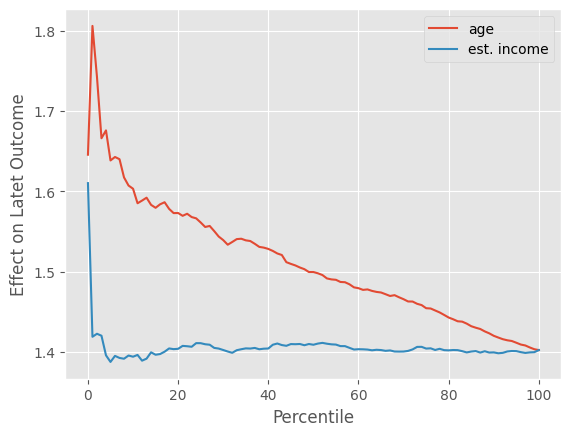

In [9]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "latent_outcome", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Latet Outcome");

Again, the latent outcome is very nice. Due to its linearity, our expectations match reality pretty closely. But in real life, we don't care (nor have) the latent outcome. All we have is conversion. In conversion, things look a lot more complicated. If we plot the cumulative effect curves, `age` still shows some treatment effect heterogeneity, starting above the ATE and slowly converging towards it. This means that the higher the age, the higher the treatment effect. So far so good. This is what we would expect. 

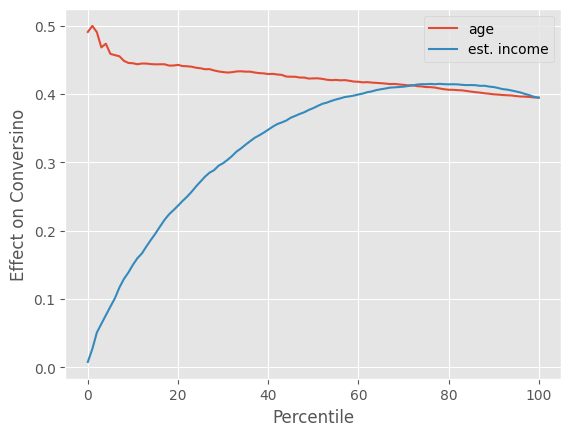

In [10]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");

However, we also have A LOT of treatment effect heterogeneity by `estimated_income`. Customers with higher `estimated_income` have much lower treatment effect, which causes the cumulative effect curve to go all the way to zero at the beginning and then slowly converge to the ATE. This tells us that, as far as personalization is concerned, `estimated_income` will generate segments that have more treatment effect heterogeneity (TEH) compared to the segments we would get with `age`. 
 
This is inconvenient right? How come the feature we know to drive effect heterogeneity, `age`, is worse for personalization when compared with a feature (`estimated_income`) we know not to modify the treatment effect? The answer lies in the **non-linearity of the outcome function**. Although `estimated_income` does not modify the effect of the nudge on the latent outcome, it does once we transform that latent outcome to conversion (at least indirectly). Conversion is not linear. This means that **its derivative changes depending on where you are**. Since conversion can only go up to 1, if it is already very high, it will be hard to increase it. In other words, the derivative of high conversion is very low. But because conversion is also bounded at zero, it will also have a low derivative if it is already very low. Conversion follows an S shape, with low derivatives at both ends. We can see that by plotting the average conversion by estimated income bins (bins of 100 by 100).

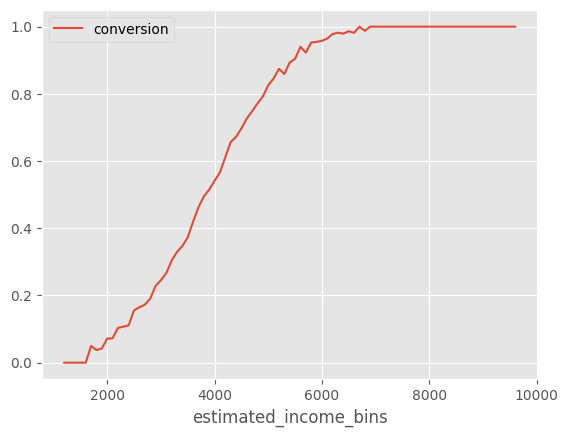

In [11]:
(df
 .assign(estimated_income_bins=(df["estimated_income"]/100).astype(int)*100)
 .groupby("estimated_income_bins")
 [["conversion"]]
 .mean()
 .plot()
);

Notice how the slope (derivative) of this curve is very small when conversion is very high. It is also small when conversion is very low (although that is harder to see due to the small sample in that region). With this information, we can now explain why `estimated_income` generates segments with high treatment effect heterogeneity. 
 
Since `estimated_income` is highly predictive of conversion, we can say that customers with different `estimated_income` fall in different places of the S shaped conversion curve. Customers with very high or very low `estimated_income` fall at the extremes of the curve, where the derivative is lower, meaning that increasing conversion is harder, which in turns means that the treatment effect is likely to be small. On the other hand, customers with reported income in the middle of the range also fall in the middle of the conversion curve, where the derivative is higher and, hece, the treatment effect will likely also be higher. I say likely because, in theory, it is possible for a variable to have such a strong effect modification force that it dominates the change in derivative we see as we traverse the conversion curve. However, at least from my experience, the curvature of the S shaped conversion tends to dominate every other effect modification we have. 
 
This is not just me, though. Here is a slide I got from Susan Atheys' presentation for the Columbia Data Science Institute. Here, she is discussing the effect of a nudge to get students to apply for federal financial aid in order to pay for college. It's also a conversion problem. What she finds is that the best strategy is to target those students that are already likely to convert. She also says it is a bad idea to target those with low probability of conversion
 
![image.png](data/img/hte-binary-outcome/slide-susan-athey.png)
 
Wait a minute! But that is not what you first said! You said that both very high and very low conversions have low derivative and hence, low treatment effect!
 
Well, that is correct. However, in real life, conversion rarely spams the entire S shaped curve. What we usually have is everyone smooshed at one or the other end of the curve. In business terms, your average conversion is rarely 50%. More often than not, it is something like 70 to 90% or something like 1 to 20%. In these more likely situations, targeting those with a high baseline can be a good or a bad idea. 
 
Here is what I mean: Let's take the same latent outcome from before, but now generate a situation where conversion is low on average, by setting it to `latent_outcome > 2`. Next, let's craft a situation where conversion is high by setting `latent_outcome > -2`.

In [12]:
df["conversion_low"] = conversion = (latent_outcome > 2).astype(int)
df["conversion_high"] = conversion = (latent_outcome > -2).astype(int)

print("Avg. Low Conversion: ", df["conversion_low"].mean())
print("Avg. High Conversion: ", df["conversion_high"].mean())

Avg. Low Conversion:  0.12119
Avg. High Conversion:  0.9275


Based on what we know about the non linearity of conversion, we can already predict what will happen. For the low conversion situation, targeting those with high baseline conversion (high `estimated_income`) will be much more effective. That's because we are at the left side of the S shaped conversion curve, where the derivative will be smaller the lower the baseline conversion. In this region, **high baseline conversion will translate to high treatment effect**. Therefore, we should nudge those with high baseline conversion, which will be those with higher `estimated_income`.

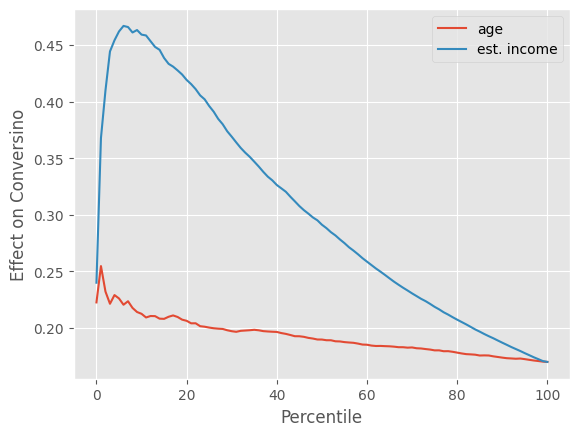

In [13]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_low", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");
plt.legend();

Just like we predicted, those with high `estimated_income`, which translates to high baseline conversion, have a much higher treatment effect. 
 
Now, for the other situation where conversion is high, on average, those with **high baseline conversion will have a lower treatment effect**. Hence, it is a bad idea to target those with high `estimated_income`. We can see this by the inverted cumulative effect curve, which shows those with high `estimated_income` as having a lower treatment effect.

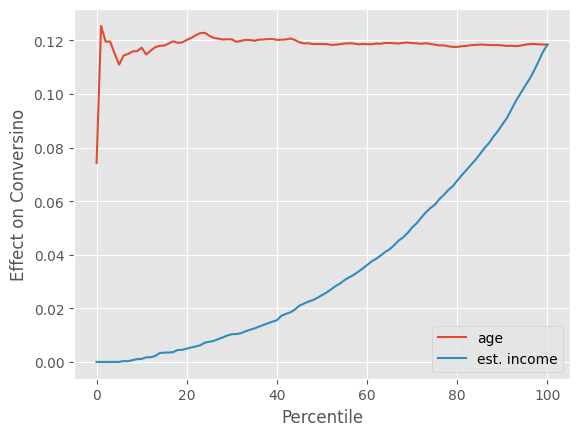

In [14]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_high", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino")
plt.legend();

To summarize, what we saw is that, when the outcome is binary, the treatment effect tends to be dominated by the curvature (derivative) of the logistic function. 
 
![image.png](data/img/hte-binary-outcome/logistic.png)
 
For instance, in our conversion problem, if the **average conversion is low**, we are at to the left of the logistic curve and the **treatment effect will be higher at high baseline conversion**. This would translate to a nudge policy that advocates for treating (nudging) those customers with an already high probability of conversion. On the other hand, if the **average conversion is high**, we will be to the right side of the logistic curve, where the derivative (and hence the treatment effect) will be **higher for those customers with lower baseline conversion**. 
 
This is certainly a lot to remember, but we can definitely simplify: **just treat whomever is closer to a baseline conversion of 50%**. The mathematical argument here is pretty solid: the derivative of the logistic is at its peak at 50%, so just treat units closer to that point. 
 
What is even nicer is that this is one of the rare cases where common knowledge matches the math. In marketing, where these conversion problems are very common, there is a belief that we should not target lost bets (those with very low conversion probability) nor sure wins (those with very high conversion probability). Instead, we should target those in the middle. This is pretty fascinating, since it is the exact same thing we figured using a more formal causal argument. 

# Continues Treatment and Non Linearity
 
We've explored in depth just one example of binary outcome making Heterogeneous Treatment Effect analysis harder. But this phenomena goes beyond the conversion problem from marketing. For instance, in 2021, the world managed to deliver its first batch of approved COVID19 vaccines to the general public. Back then, a crucial question was who should receive the vaccine first. This is, not surprisingly, a Heterogeneous Treatment Effect problem. Policy makers would like to vaccinate those who would benefit the most first. In this situation, the treatment effect is avoiding death or hospitalization. So, whose death or hospitalization decreased the most when given a shot? In most countries, they were the elderly and those with prior health conditions (comorbidities). Now, these are the people that are **more likely to die when getting COVID19**. Also covid mortality rate is thankfully much lower than 50%, which puts us to the left of logistic function. In this region, by the same argument we made for marketing, it would make sense to treat those with a high baseline probability of death when getting COVID19, which are precisely the groups we’ve mentioned earlier. Is this a coincidence? Maybe. Keep in mind that I'm not a health expert, so I might be very wrong here. But the logic makes a lot of sense to me. 
 
In both cases, marketing nudges and COVID19 vaccines, **the key complicating factor for Treatment Effect Heterogeneity is the non-linearity of the outcome function** $Y(0)$. This nonlinearity makes it so that, as we go from $Y(0)$ to $Y(1)$, the increase in the outcome is primarily due to the curvature in the outcome function. We saw how this happened in binary outcome, where $E[Y|X]$ follows a logistic shape. But this is even more general. In fact, it is a problem that keeps popping up in business, especially if the treatment is a continuous variable. Let's go through one last example to make this idea more clear.
 
Let's consider the classic pricing problem. You are working for a streaming company, like Netflix or HBO. A key question the company wants answered is what price to charge customers. In order to answer that, they run an experiment where they randomly assign customers to different priced deals: 5 BLR/month, 10 BRL/month, 15 BRL/month or 20 BRL/month. By doing so, they hope to answer not just how sensitive customers are to price increases, but also if some types of customers are more sensitive than others. In the plot below, you can see the results from that experiment broken down by two customer segments: `A`, customers with higher estimated income, and `B`, customers with lower estimated income. 

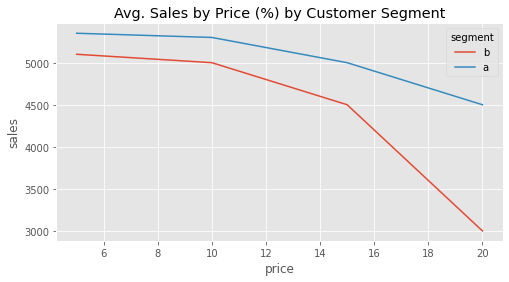

In [16]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

With this data, the company wishes to answer the following question: who is more sensitive to discounts? In other words, how can we **rank customers by their sensitivity to price (price elasticity of sales)**? By looking at the curve, we get a feeling that segment `A` is overall less sensitive to discount, even though it generates more revenues. However, we can also see that there is some curvature there. In fact, if we take this curvature into account, the ranking of the treatment effect is no longer just between `A` and `B` customers. The treatment effect will also depend on where they are in the treatment curve. For example, the treatment effect of going from 15 BRL to 10 BRL on customers of segment `A` is higher than the treatment effect of going from 5BRL to 10BRL on customers of segment `B`:
 
$$
E[Y(10) - Y(5) | Seg=B] < E[Y(15) - Y(10) | Seg=A]
$$
 
If we where to order the resulting treatment effects for this experiment, it would look something like this:

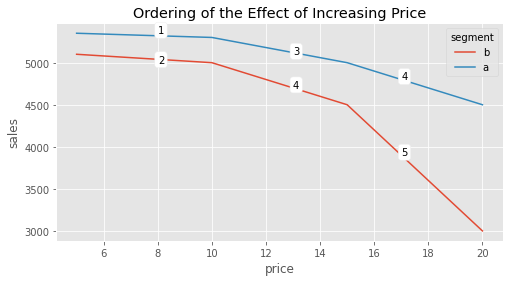

In [36]:
plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")

plt.annotate("1", (8, 5350), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("2", (8, 5000), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("3", (13, 5100), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (13, 4700), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (17, 4800), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("5", (17, 3900), bbox=dict(boxstyle="round", fc="1"))

plt.title("Ordering of the Effect of Increasing Price");

Just like in the case where the outcome was binary, in this example, **the treatment effect is correlated with the outcome**. The higher the sales (lower the price), the lower the absolute treatment effect; the lower the sales (higher the price) the lower the absolute treatment effect. But in this case, the situation is even more complicated because the **effect is not only correlated with the outcome, but with the treatment level**. This makes answering counterfactual questions trickier. For example, pretend for a moment that your experimental data actually looks like the following plot, where you test higher prices for the segment `A` (rich population) but only lower prices for the `A` population. This is very common, as firms often want to experiment around the treatment they think is more reasonable.

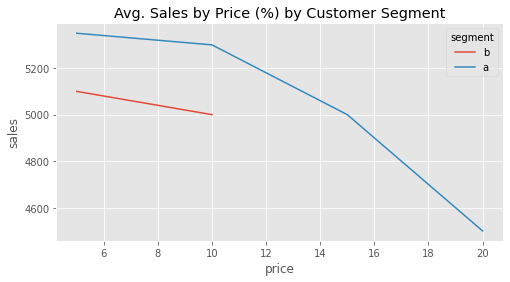

In [45]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data.loc[lambda d: (d["segment"] == "a") | (d["price"] < 12) ], x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

Now, if you naively aggregate the results of the treatment effect, it will look like segment `A` is much more elastic (has higher absolute treatment effect) to price increase than segment `B`. But that is only because, for segment `B`, you've explored the low treatment effect region.
 
So what can you do when treatment effects change depending on where you are in terms of both treatment and outcome? To be honest, this is still an active area of research. In practical terms, the best thing you can do is to be **very careful** when trying to answer which type of customer is more sensitive to the treatment. Make sure that the compared customer types all had the same treatment distribution. And, if not, be very skeptical of extrapolating the treatment effect. For instance, in the example above, even though customer `B` looks less sensitive to price increase, you don't know if that will still be the case if you assign higher prices beyond 10BRL to this segment.
 
Another thing you can try to do is to linearize the response curve. The idea here is to get rid of the curvature by transforming the treatment or the outcome (or both) so that the relationship between them looks like a line. Since a line has constant derivative, this would get rid of the problem of the treatment effect changing depending on where you are in the curve. As an example, if we take our price variable and transform it by making it negative, exponentiating it by 4 and reversing the sign, we get a somewhat linear(ish) relationship. In this transformed data, the statement that `A` is less sensitive to price increases then `B` makes much more sense, since it now does not depend on where we are at the curve.

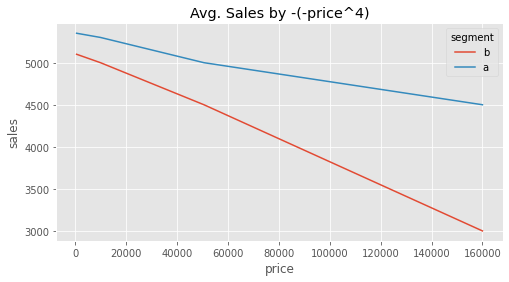

In [109]:

plt.figure(figsize=(8,4))
sns.lineplot(data=data.assign(price = lambda d: -1*(-d["price"]**4)),
             x="price", y="sales", hue="segment")
plt.title("Avg. Sales by -(-price^4)");

However, this approach has many drawbacks. First, it is not always possible to linearize a curve. In our example you can clearly see that this linearization is not perfect. But more importantly, sometimes it makes no business sense to discard the curvature. In our pricing example, it may very well be that we are fine in treating customer `A` at price 15 as more sensitive than customer `B` at price 5. This would lead us to a sound decision of decreasing price for customer `A` from 15 to 10, but not doing anything to the price of customer `B`.

## Key Concepts
 
I realize I might have brought more questions than answers, but sometimes the best we can do about a problem is to be very aware of it. In this chapter, I hope I've managed to open your eyes to the complications that arise when the outcome we care about is non-linear. 
 
This is a common and more studied problem with binary outcomes. In this case, the treatment effect tends to be higher the closer we are to an average outcome of 0.5. Since the outcome is bounded at 0 and 1, effects tend to be very small if we are too close to 0 or 1. 
 
Things get more complicated with non-linearities arising in continuous outcome situations. Here, the best you can do is think very carefully about the problem. Try to answer if you care more about treatment effect regardless of treatment baseline or if the baseline is important. That alone will be a valuable guiding principle. 
 
## Reference
 
Most of the things written here are from my own experience with this problem. However, I did find one academic articles that touch on this subject: *Causal Classification: Treatment Effect Estimation vs. Outcome Prediction*, by Fernández-Loría and Provost talk about the case where treatment effect is correlated with the outcome variable. 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).